# Bitcoin Price Prediction Using Historical Data And Wikipedia Edits Data

### Project Overview

**In this project, we'll predict the future price of Bitcoin. We'll use historical data on the price of Bitcoin, along with data from Wikipedia about edits to the Bitcoin page. We'll merge and combine this data, then use it to train a random forest model that will tell us if Bitcoin prices will increase or decrease tomorrow. We'll then switch to an XGBoost model and better predictors to improve accuracy.**

## Downloading Edits From Wikipedia

 

**_In the wikipedia official page of Bitcoin,under the section of edits,the editor describes why they made the edit.So by looking at this edit history we can do two things_**
- **_We can get a proxy about how intrested the public was in bicoin,based on the total no.of edits_**
- **_We can understand about the sentiment of how people felt about bitcoin by looking at those comments and analyzing them_** 

In [ ]:
#install mwclient
!pip install mwclient

In [3]:
import mwclient  #media wiki client -> created to access data about wikipedia and other wiki's
import time

site = mwclient.Site('en.wikipedia.org')
page = site.pages['Bitcoin']

In [4]:
#Fetching list of revisions
revs = list(page.revisions())

In [5]:
revs[0]

OrderedDict([('revid', 1120484887),
             ('parentid', 1120476939),
             ('user', 'Grayfell'),
             ('timestamp',
              time.struct_time(tm_year=2022, tm_mon=11, tm_mday=7, tm_hour=7, tm_min=18, tm_sec=41, tm_wday=0, tm_yday=311, tm_isdst=-1)),
             ('comment',
              'Coinmarketcap.com is not a reliable source. [[WP:INFOBOXFLAG]]')])

A revision is an ordered dictionary,which is a special python class which works as a list and dictionary combined  
**revid** and **parentid** are keys in the dictionary.

We can see that this is the most recent edit, happened on 7th Nov 2022

In [6]:
#Sorting the revisions in the reverse order
revs = sorted(revs, key=lambda rev: rev["timestamp"]) 

In [7]:
revs[0]

OrderedDict([('revid', 275832581),
             ('parentid', 0),
             ('user', 'Pratyeka'),
             ('timestamp',
              time.struct_time(tm_year=2009, tm_mon=3, tm_mday=8, tm_hour=16, tm_min=41, tm_sec=7, tm_wday=6, tm_yday=67, tm_isdst=-1)),
             ('comment', 'creation (stub)')])

Now here we get the first ever edit in the Bitcoin page, which is on 8th Mar 2009

## Sentimental Analysis On Page Edits

### Using Transformers For sentimental Analysis Of Edits

**Transformers** is a library that lets you use a lot of pre-trained deep learning models and here we use a **sentiment-analysis** model

In [ ]:
#Installing transformers
!pip install transformers

In [9]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [10]:
#Define a function to find sentiment in a text
def find_sentiment(text):
    sent = sentiment_pipeline([text[:250]])[0]  #limmiting it to 250 char to run it faster
    score = sent["score"]
    if sent["label"] == "NEGATIVE":
        score *= -1                             #converts the score into neg num if sentiment is negative
    return score

In [13]:
#testing the func
find_sentiment("It's so disgusting to listen that")

-0.9995827078819275

Now we process each of our revisions to both count no.of edits per day and figure out avg sentiment per day

In [21]:
edits = {}

for rev in revs:        
    date = time.strftime("%Y-%m-%d", rev["timestamp"])  #convert time in named tuple to str using strftime(string format time)  
    if date not in edits:
        edits[date] = dict(sentiments=list(), edit_count=0)
    
    edits[date]["edit_count"] += 1
    
    comment = rev.get("comment", "")             #extracting comment and passing it for sentimental analysis
    edits[date]["sentiments"].append(find_sentiment(comment))

In [22]:
from statistics import mean

#Finding mean sentiment of an edit on a day and percentage of -ve sentiment
for key in edits:
    if len(edits[key]["sentiments"]) > 0:
        edits[key]["sentiment"] = mean(edits[key]["sentiments"])
        edits[key]["neg_sentiment"] = len([s for s in edits[key]["sentiments"] if s < 0]) / len(edits[key]["sentiments"])
    else:
        edits[key]["sentiment"] = 0
        edits[key]["neg_sentiment"] = 0
    
    del edits[key]["sentiments"]

In [23]:
edits

{'2009-03-08': {'edit_count': 4,
  'sentiment': -0.5505250096321106,
  'neg_sentiment': 0.75},
 '2009-08-05': {'edit_count': 1,
  'sentiment': 0.7481208443641663,
  'neg_sentiment': 0.0},
 '2009-08-06': {'edit_count': 2,
  'sentiment': 0.995745837688446,
  'neg_sentiment': 0.0},
 '2009-08-14': {'edit_count': 1,
  'sentiment': 0.930020809173584,
  'neg_sentiment': 0.0},
 '2009-10-13': {'edit_count': 2,
  'sentiment': -0.2275007963180542,
  'neg_sentiment': 0.5},
 '2009-11-18': {'edit_count': 1,
  'sentiment': 0.8839504718780518,
  'neg_sentiment': 0.0},
 '2009-12-08': {'edit_count': 1,
  'sentiment': -0.9869275689125061,
  'neg_sentiment': 1.0},
 '2009-12-17': {'edit_count': 1,
  'sentiment': -0.9975171089172363,
  'neg_sentiment': 1.0},
 '2010-02-23': {'edit_count': 1,
  'sentiment': -0.9994946718215942,
  'neg_sentiment': 1.0},
 '2010-03-18': {'edit_count': 1,
  'sentiment': 0.8758771419525146,
  'neg_sentiment': 0.0},
 '2010-04-13': {'edit_count': 4,
  'sentiment': 0.8443556129932404

### Converting Sentiment Data Into A Dataframe And Processing Edits

In [24]:
import pandas as pd

edits_df = pd.DataFrame.from_dict(edits, orient="index") #each dictionary is a seperate row

In [25]:
edits_df

,edit_count,sentiment,neg_sentiment
2009-03-08,4,-0.550525,0.75
2009-08-05,1,0.748121,0.00
2009-08-06,2,0.995746,0.00
2009-08-14,1,0.930021,0.00
2009-10-13,2,-0.227501,0.50
...,...,...,...
2022-11-03,2,-0.991209,1.00
2022-11-04,2,-0.990773,1.00
2022-11-05,1,0.998046,0.00
2022-11-06,1,0.563275,0.00


In [26]:
edits_df.index = pd.to_datetime(edits_df.index)

**Normally the bitcoin price is available everyday by continuos trading, but here the data has lot of gaps because wikipedia edits don't happen everyday. So we've to cover up those missing values for which we need a dataframe without any missing values.**

In [27]:
from datetime import datetime

dates = pd.date_range(start="2009-03-08",end=datetime.today())

In [30]:
dates 

DatetimeIndex(['2009-03-08', '2009-03-09', '2009-03-10', '2009-03-11',
               '2009-03-12', '2009-03-13', '2009-03-14', '2009-03-15',
               '2009-03-16', '2009-03-17',
               ...
               '2022-11-02', '2022-11-03', '2022-11-04', '2022-11-05',
               '2022-11-06', '2022-11-07', '2022-11-08', '2022-11-09',
               '2022-11-10', '2022-11-11'],
              dtype='datetime64[ns]', length=4997, freq='D')

In [31]:
edits_df = edits_df.reindex(dates, fill_value=0) #fill missingval with 0 as we don't have any data for that day
edits_df

,edit_count,sentiment,neg_sentiment
2009-03-08,4,-0.550525,0.75
2009-03-09,0,0.000000,0.00
2009-03-10,0,0.000000,0.00
2009-03-11,0,0.000000,0.00
2009-03-12,0,0.000000,0.00
...,...,...,...
2022-11-07,2,-0.133408,0.50
2022-11-08,0,0.000000,0.00
2022-11-09,0,0.000000,0.00
2022-11-10,0,0.000000,0.00


In [32]:
#Finding how many edits were there in the last month 
rolling_edits = edits_df.rolling(30, min_periods=30).mean()

In [33]:
rolling_edits

,edit_count,sentiment,neg_sentiment
2009-03-08,NaN,NaN,NaN
2009-03-09,NaN,NaN,NaN
2009-03-10,NaN,NaN,NaN
2009-03-11,NaN,NaN,NaN
2009-03-12,NaN,NaN,NaN
...,...,...,...
2022-11-07,1.066667,-0.114622,0.278333
2022-11-08,1.066667,-0.114622,0.278333
2022-11-09,1.066667,-0.114622,0.278333
2022-11-10,1.066667,-0.114622,0.278333


In [34]:
#Removing NaN values
rolling_edits = rolling_edits.dropna()
rolling_edits

,edit_count,sentiment,neg_sentiment
2009-04-06,0.133333,-0.018351,0.025000
2009-04-07,0.000000,0.000000,0.000000
2009-04-08,0.000000,0.000000,0.000000
2009-04-09,0.000000,0.000000,0.000000
2009-04-10,0.000000,0.000000,0.000000
...,...,...,...
2022-11-07,1.066667,-0.114622,0.278333
2022-11-08,1.066667,-0.114622,0.278333
2022-11-09,1.066667,-0.114622,0.278333
2022-11-10,1.066667,-0.114622,0.278333


In [35]:
#Writing it into a .csv file
rolling_edits.to_csv("wikipedia_edits.csv")

## Downloading Bitcoin Price Data

**Now we download the price data of bitcoin from yahoo finance api using _yfinance_  and combine that with our wikipedia data and predict prices using a machine learning model**

In [ ]:
#installing yfinance
!pip install yfinance

In [38]:
import yfinance as yf
import os
import pandas as pd

In [115]:
btc_ticker = yf.Ticker("BTC-USD") #Ticker object downloads the base history of bitcoin in USD symbol

In [116]:
btc = btc_ticker.history(period="max")
btc

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0,0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0,0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0,0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0,0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0,0
...,...,...,...,...,...,...,...
2022-11-07 00:00:00+00:00,20924.621094,21053.246094,20489.972656,20602.816406,53510852236,0,0
2022-11-08 00:00:00+00:00,20600.671875,20664.607422,17603.544922,18541.271484,118992465607,0,0
2022-11-09 00:00:00+00:00,18543.761719,18590.458984,15682.692383,15880.780273,102905151606,0,0


In [117]:
btc.index = pd.to_datetime(btc.index).date #Remove time from datetime
btc

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,0
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0,0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0,0
...,...,...,...,...,...,...,...
2022-11-07,20924.621094,21053.246094,20489.972656,20602.816406,53510852236,0,0
2022-11-08,20600.671875,20664.607422,17603.544922,18541.271484,118992465607,0,0
2022-11-09,18543.761719,18590.458984,15682.692383,15880.780273,102905151606,0,0
2022-11-10,15883.158203,18054.312500,15834.018555,17586.771484,83202283721,0,0


In [118]:
#Deleting unnecessary cols
del btc["Dividends"]
del btc["Stock Splits"]

In [119]:
btc.columns = [c.lower() for c in btc.columns]

## Data Visualization

In [120]:
#Importing necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

import plotly.graph_objs as go
from plotly.offline import plot

#for plotting
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [122]:
#Plotting Close Price
layout=go.Layout(title='Bitcoin Close Prices',xaxis=dict(title='Date',titlefont=dict(family='Courier New, monospace',size=19,color='#7f7f7f')) ,
                 yaxis=dict(title='Close',titlefont=dict(family='Courier New, monospace',size=19,color='#7f7f7f')))
btc_data = [{'x':btc.index , 'y':btc['close']}]
plot = go.Figure(data=btc_data,layout=layout)
plot.show(renderer="colab")

### Analysing Relations Among Features

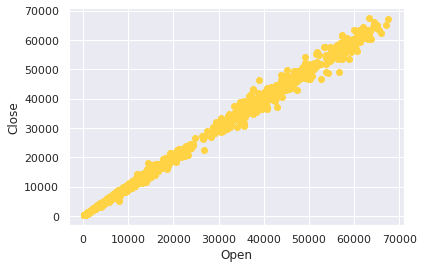

<Figure size 360x360 with 0 Axes>

In [123]:
#Close vs Open
plt.scatter(btc['open'], btc['close'],color='#ffd343')
plt.xlabel('Open')
plt.ylabel('Close')
plt.figure(figsize=(5, 5))
plt.show()

Text(0.5, 1.0, 'Open vs Close')

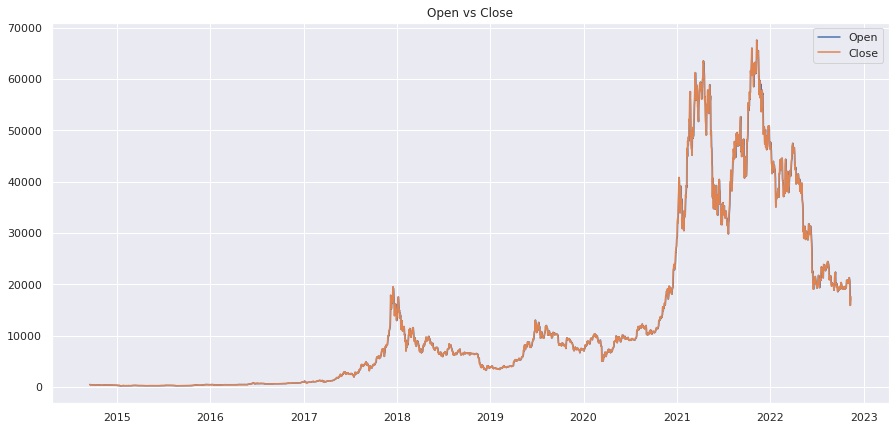

In [124]:
btc['open'].plot(label='Open',figsize=(15,7))
btc['close'].plot(label='Close')
plt.legend()
plt.title("Open vs Close")

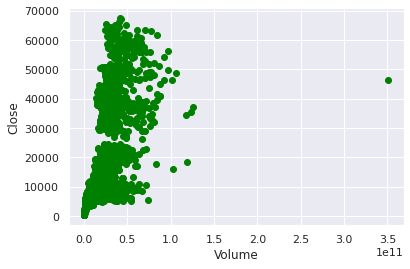

<Figure size 360x360 with 0 Axes>

In [125]:
#CLose vs Volume
plt.scatter(btc['volume'], btc['close'],color='Green')
plt.xlabel('Volume')
plt.ylabel('Close')
plt.figure(figsize=(5, 5))
plt.show()

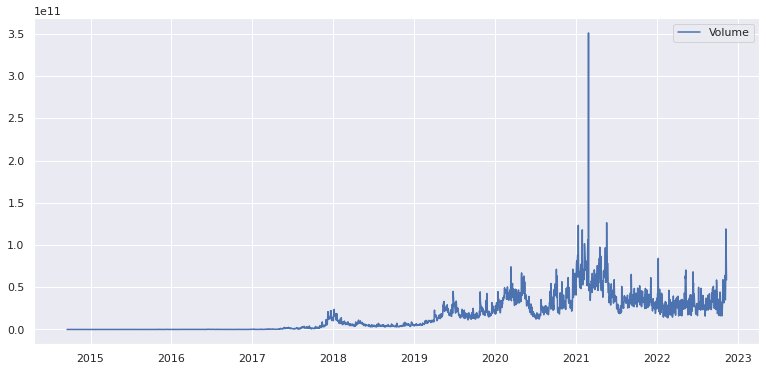

In [126]:
btc['volume'].plot(label='Volume',figsize=(13,6))
plt.legend()

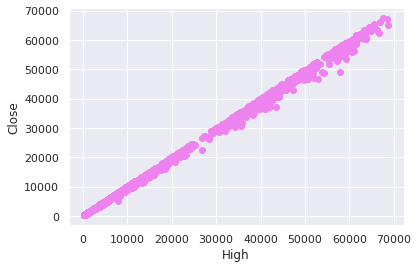

<Figure size 360x360 with 0 Axes>

In [135]:
#High vs Close
plt.scatter(btc['high'], btc['close'],color='violet')
plt.xlabel('High')
plt.ylabel('Close')
plt.figure(figsize=(5, 5))
plt.show()

Text(0.5, 1.0, 'High vs Close')

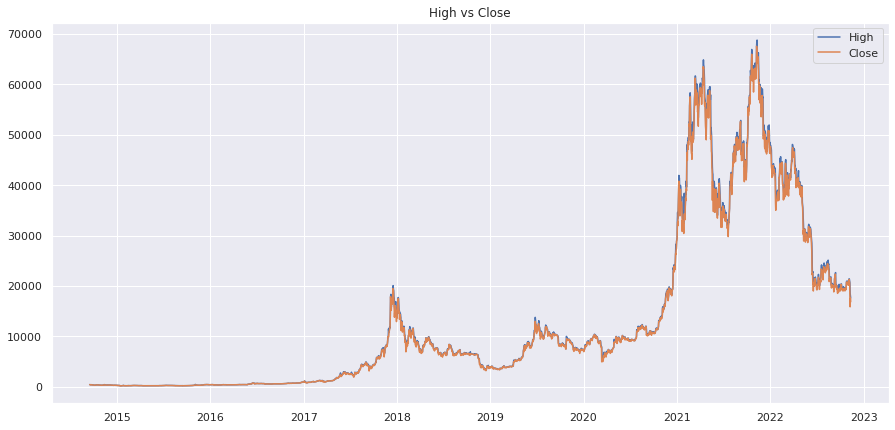

In [128]:
btc['high'].plot(label='High',figsize=(15,7))
btc['close'].plot(label='Close')
plt.legend()
plt.title("High vs Close")

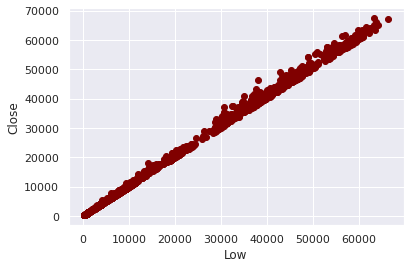

<Figure size 360x360 with 0 Axes>

In [129]:
#Low vs Close
plt.scatter(btc['low'], btc['close'],color='Maroon')
plt.xlabel('Low')
plt.ylabel('Close')
plt.figure(figsize=(5, 5))
plt.show()

Text(0.5, 1.0, 'Low vs Close')

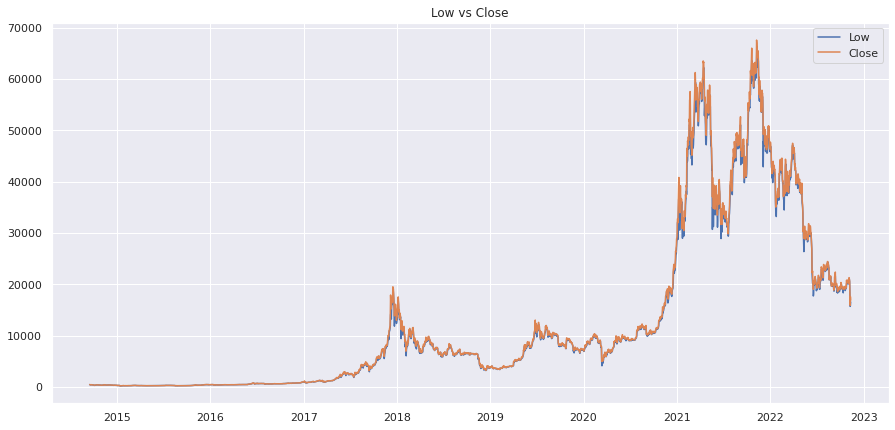

In [130]:
btc['low'].plot(label='Low',figsize=(15,7))
btc['close'].plot(label='Close')
plt.legend()
plt.title("Low vs Close")

### Correlation Between features

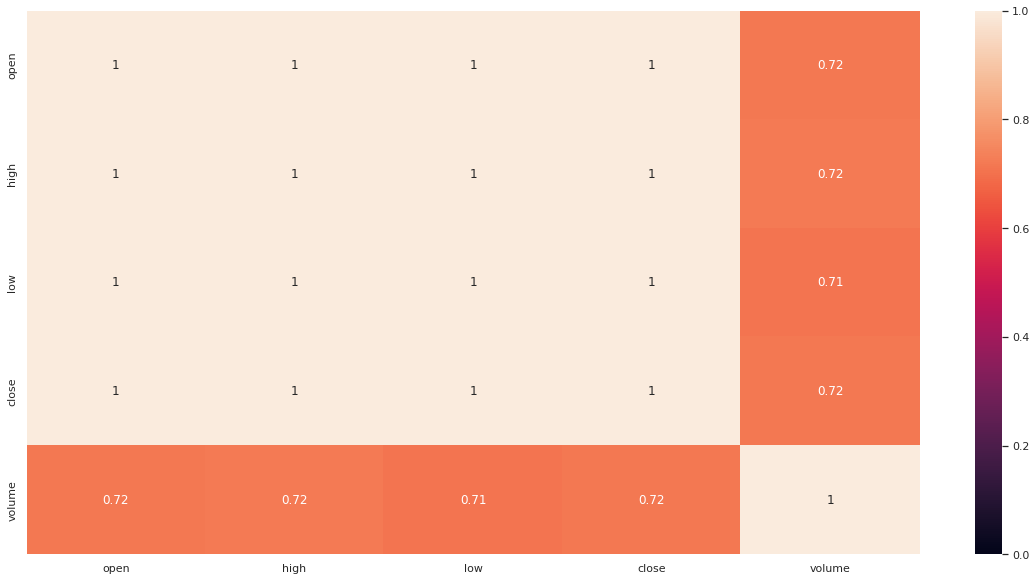

In [132]:
sns.set_theme()
plt.figure(1 , figsize = (20 , 10))
cor = sns.heatmap(btc.corr(), annot = True ,vmin=0, vmax=1)

Text(0.5, 1.0, 'Relation between Close, Open, High and Low ')

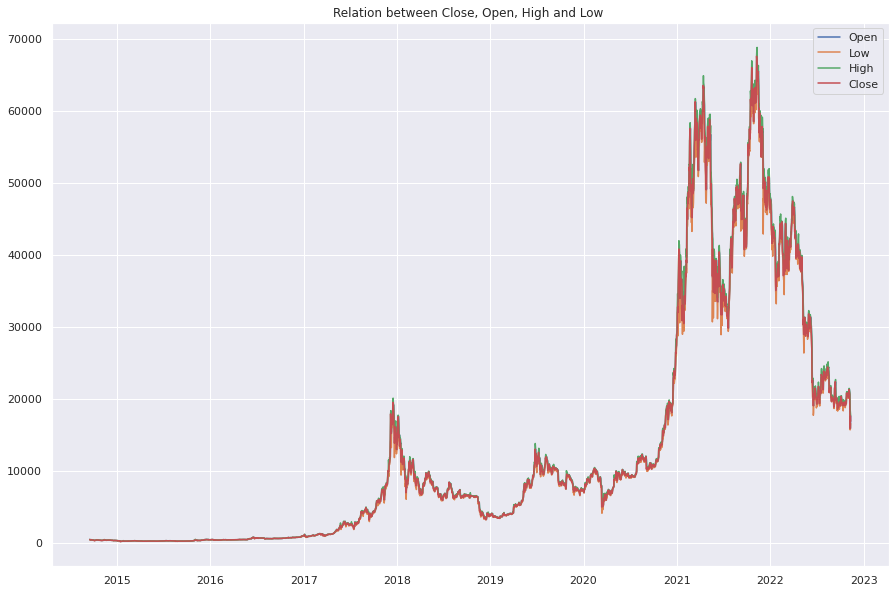

In [134]:
btc['open'].plot(label='Open',figsize=(15,10))
btc['low'].plot(label='Low')
btc['high'].plot(label='High')
btc['close'].plot(label='Close')
plt.legend()
plt.title("Relation between Close, Open, High and Low ")

**From  the  above  plots  and  graphs, we  can  understand  that  the  features  Close , high , Low and  Open  have  linear relationship(correlation)  among  them**

## Preparing Data For Machine Learning

In [57]:
wiki = pd.read_csv("wikipedia_edits.csv", index_col=0, parse_dates=True)
wiki 

,edit_count,sentiment,neg_sentiment
2009-04-06,0.133333,-0.018351,0.025000
2009-04-07,0.000000,0.000000,0.000000
2009-04-08,0.000000,0.000000,0.000000
2009-04-09,0.000000,0.000000,0.000000
2009-04-10,0.000000,0.000000,0.000000
...,...,...,...
2022-11-07,1.066667,-0.114622,0.278333
2022-11-08,1.066667,-0.114622,0.278333
2022-11-09,1.066667,-0.114622,0.278333
2022-11-10,1.066667,-0.114622,0.278333


In [58]:
btc = btc.merge(wiki, left_index=True, right_index=True)

In [59]:
btc

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,-0.232191,0.532718
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,-0.232760,0.532718
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,-0.235415,0.549385
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,-0.233185,0.549385
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,-0.204017,0.532718
...,...,...,...,...,...,...,...,...
2022-11-07,20924.621094,21053.246094,20489.972656,20602.816406,53510852236,1.066667,-0.114622,0.278333
2022-11-08,20600.671875,20664.607422,17603.544922,18541.271484,118992465607,1.066667,-0.114622,0.278333
2022-11-09,18543.761719,18590.458984,15682.692383,15880.780273,102905151606,1.066667,-0.114622,0.278333
2022-11-10,15883.158203,18054.312500,15834.018555,17586.771484,83202283721,1.066667,-0.114622,0.278333


In [60]:
btc["tomorrow"] = btc["close"].shift(-1) #takes closing price of a day and shifts it a day backward

In [63]:
btc["target"] = (btc["tomorrow"] > btc["close"]).astype(int) #If price went up 1, else 0
btc

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow,target
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,-0.232191,0.532718,424.440002,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,-0.232760,0.532718,394.795990,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,-0.235415,0.549385,408.903992,1
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,-0.233185,0.549385,398.821014,0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,-0.204017,0.532718,402.152008,1
...,...,...,...,...,...,...,...,...,...,...
2022-11-07,20924.621094,21053.246094,20489.972656,20602.816406,53510852236,1.066667,-0.114622,0.278333,18541.271484,0
2022-11-08,20600.671875,20664.607422,17603.544922,18541.271484,118992465607,1.066667,-0.114622,0.278333,15880.780273,0
2022-11-09,18543.761719,18590.458984,15682.692383,15880.780273,102905151606,1.066667,-0.114622,0.278333,17586.771484,1
2022-11-10,15883.158203,18054.312500,15834.018555,17586.771484,83202283721,1.066667,-0.114622,0.278333,16752.896484,0


In [64]:
btc["target"].value_counts()

1    1592
0    1386
Name: target, dtype: int64

## Model Building

### Creating Baseline Random Forest Classifier 

In [65]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)

train = btc.iloc[:-200] # leave the last 200 days for testing and remaining for training
test = btc.iloc[-200:]

predictors = ["close", "volume", "open", "high", "low", "edit_count", "sentiment", "neg_sentiment"]
model.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=50, random_state=1)

Here we don't use cross validation or any normal machine learning techniques while creating the model because to respect the order of the data as it is time series.Otherwise, it will result to unrealistic scenarios

In [66]:
#Finding the accuracy of the random forest classifier
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["target"], preds)

0.4444444444444444

The attained accuracy is not a great one and it could be improved a lot

### Evaluating Error With Backtesting

In [67]:
#  Function to predict price
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined

In [68]:
#Function for backtesting
def backtest(data, model, predictors, start=1095, step=150):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

What Backtesting does is, Here we have data from 2014 to 2022.Let's take data from 2014 to 2017..It uses that to predict prices for 2018.The let's take data from 2014 to 2018..it uses that to predict 2019 and so on... until we have predictions for most of our dataset

We can't start any predictions from 2014 because we don't hve any historical data before it.So,here **start** defines how much historical data you wanna use before creating predictions,here 1095 indicates about 3 years of historical data and **step** defines the period at which we wanna make predictions for after start,here 150 indicates about new predictions every 5 months 


### Building An XGBoost Model

In [69]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=1, learning_rate=.1, n_estimators=200)
predictions = backtest(btc, model, predictors)

In [70]:
predictions["predictions"].value_counts()

1    1281
0     602
Name: predictions, dtype: int64

In [71]:
#Finding accuracy
precision_score(predictions["target"], predictions["predictions"])

0.5027322404371585

We can observe a slight improvement in the accuracy of predictions but still can be improved

### Improving Precision With Trends

We can improve accuracy by adding more predictors. Generally it's a best way to improve accuracy is to either get more data or generate new predictors.

Here we define a function **compute_rolling** which finds trend in various columns over the last period using horizons specified.

In [74]:
def compute_rolling(btc): 
    horizons = [2,7,60,365]  #days
    new_predictors = ["close", "sentiment", "neg_sentiment"]

    for horizon in horizons:
        rolling_averages = btc.rolling(horizon, min_periods=1).mean()

        ratio_column = f"close_ratio_{horizon}"
        btc[ratio_column] = btc["close"] / rolling_averages["close"]
        
        edit_column = f"edit_{horizon}"
        btc[edit_column] = rolling_averages["edit_count"]

        rolling = btc.rolling(horizon, closed='left', min_periods=1).mean()  # we assign close = left to not include current target in the rolling avg of previous values
        trend_column = f"trend_{horizon}" 
        btc[trend_column] = rolling["target"]

        new_predictors+= [ratio_column, trend_column, edit_column]
    return btc, new_predictors

In [75]:
btc, new_predictors = compute_rolling(btc.copy())

In [76]:
predictions = backtest(btc, model, new_predictors)

In [78]:
#Finding accuracy
precision_score(predictions["target"], predictions["predictions"])

0.54419595314164

In [79]:
predictions

,target,predictions
2017-09-16,0,1
2017-09-17,1,0
2017-09-18,0,0
2017-09-19,0,1
2017-09-20,0,1
...,...,...
2022-11-07,0,1
2022-11-08,0,1
2022-11-09,1,1
2022-11-10,0,1


## Steps to Improve:

-  **Data for sentiment analysis can also be scrapped from news articles, tweets or Google trends instead of wikipedia.** 
- **You could combine others features to improve correlation and obtain better predictions.**
- **Hyper parameter tuning of the XGBoost model can produce a performing model with better precision score.**
- **Same approach can be used to predict other coins like etherium(ETH) inplace of Bitcoin(BTC).** 